<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-05-24 20:54:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-05-24 20:54:01 (13.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

In [5]:
df.isnull().sum()

Unnamed: 0        0
Unnamed: 0.1      0
loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



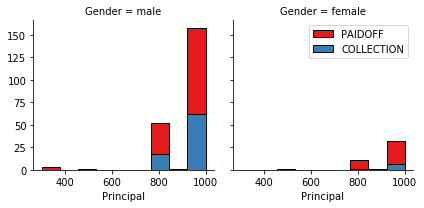

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

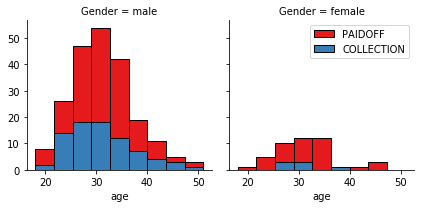

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

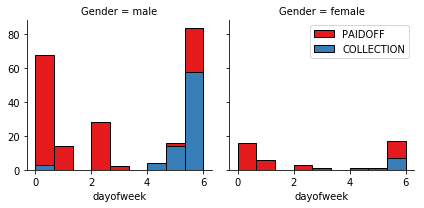

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [16]:
#shuffling data to avoid bias as dataset is ordered by target variable

from sklearn.utils import shuffle
seed = 57
df = shuffle(df,random_state = seed)
df.reset_index(inplace=True, drop=True) #resetting index

#### Feature befor One Hot Encoding

In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,33,0,Bechalor
1,1000,30,37,0,High School or Below
2,1000,30,31,1,Bechalor
3,1000,30,28,0,High School or Below
4,1000,15,35,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
#Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,33,0,0,1,0,0,0
1,1000,30,37,0,1,0,1,0,0
2,1000,30,31,1,1,1,0,0,0
3,1000,30,28,0,1,0,1,0,0
4,1000,15,35,0,0,0,0,0,1


### Feature selection

Lets define feature sets, X:

In [19]:
#.values to get an np array
X = Feature.values
X[0:5]

array([[1000,   30,   33,    0,    0,    1,    0,    0,    0],
       [1000,   30,   37,    0,    1,    0,    1,    0,    0],
       [1000,   30,   31,    1,    1,    1,    0,    0,    0],
       [1000,   30,   28,    0,    1,    0,    1,    0,    0],
       [1000,   15,   35,    0,    0,    0,    0,    0,    1]])

What are our lables?

In [20]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1, 0], inplace=True)
y = df['loan_status'].astype(int).values
y[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


array([1, 0, 1, 1, 1])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.51578458,  0.92071769,  0.34170148, -0.42056004, -1.20577805,
         2.61985426, -0.87997669, -0.07624929, -0.86968108],
       [ 0.51578458,  0.92071769,  1.00497617, -0.42056004,  0.82934003,
        -0.38170062,  1.13639374, -0.07624929, -0.86968108],
       [ 0.51578458,  0.92071769,  0.01006414,  2.37778177,  0.82934003,
         2.61985426, -0.87997669, -0.07624929, -0.86968108],
       [ 0.51578458,  0.92071769, -0.48739188, -0.42056004,  0.82934003,
        -0.38170062,  1.13639374, -0.07624929, -0.86968108],
       [ 0.51578458, -0.95911111,  0.67333883, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [23]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [24]:
#finding the best K with gridsearch CV

from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': np.arange(1,26)}
knn_GS = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5, scoring='accuracy')
knn_GS.fit(X,y)

print("Best value of K with GridSeachCV: ",knn_GS.best_params_)
print("The score of the model is: ", knn_GS.best_score_)

Best value of K with GridSeachCV:  {'n_neighbors': 7}
The score of the model is:  0.7774566473988439


In [25]:
#fitting the model with k=7

KNN_model = KNeighborsClassifier(n_neighbors=7).fit(X,y)

# Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

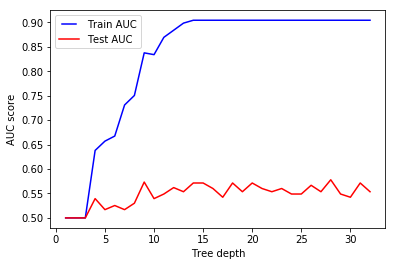

In [27]:
#finding optimum max_depth using for loop

from sklearn.metrics import roc_curve, auc

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results =[]
test_results =[]

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth).fit(X_train,y_train)
    train_pred = dt.predict(X_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)

    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [28]:
#using max_depth=4

loantree = DecisionTreeClassifier(max_depth=4).fit(X,y)

# Support Vector Machine

In [29]:
from sklearn.svm import SVC

In [30]:
#using grid search to tune hyperparameters

param_grid_svm = {'kernel': ['rbf', 'linear','poly','sigmoid']}
svm_gsc = GridSearchCV(SVC(gamma='auto'), param_grid_svm, cv=5)
svm_gsc.fit(X,y)

print(svm_gsc.best_params_)
print("The score of the model is: ", svm_gsc.best_score_)

{'kernel': 'linear'}
The score of the model is:  0.7514450867052023


In [31]:
#using the parameters from Grid Search to build the model

SVM_model = SVC(kernel='linear',gamma='auto').fit(X,y)

# Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
#using grid search to get tune hyperparameters

param_grid_LR = {'solver': ['newton-cg','liblinear', 'lbfgs', 'sag']}
lr_gsc = GridSearchCV(LogisticRegression(), param_grid_LR, cv=5)
lr_gsc.fit(X,y)

print(lr_gsc.best_params_)
print("The score of the model is: ", lr_gsc.best_score_)

{'solver': 'liblinear'}
The score of the model is:  0.7341040462427746


In [53]:
#using parameters from Grid search to build the model

lr_model = LogisticRegression(solver='liblinear', C=1).fit(X,y)

# Model Evaluation using Test set

In [35]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-05-24 20:56:59--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-05-24 20:56:59 (262 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [37]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [38]:
#preprocessing test data

#to datetime
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['due_date'] = pd.to_datetime(test_df['due_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

#categorical to numerical
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature_test = test_df[['Principal','terms','age','Gender','weekend']]

Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
#Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

#feature set
X_testset = Feature_test.values

test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'],value=[1, 0], inplace=True)

#labels
y_testset = test_df['loan_status'].astype(int).values

#normalization
X_testset = preprocessing.StandardScaler().fit(X_testset).transform(X_testset)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [39]:
print (X_testset.shape)
print (y_testset.shape)

(54, 9)
(54,)


In [40]:
#KNN model testing

yhat_knn = KNN_model.predict(X_testset)

KNN_results = {'Jaccard': round(jaccard_similarity_score(y_testset,yhat_knn),2),
               'F1-score': round(f1_score(y_testset,yhat_knn),2), 
               'LogLoss': 'NA'}

In [41]:
print (KNN_results)

{'Jaccard': 0.72, 'F1-score': 0.82, 'LogLoss': 'NA'}


In [42]:
#DecisionTree model testing

yhat_DT = loantree.predict(X_testset)

DT_results = {'Jaccard': round(jaccard_similarity_score(y_testset,yhat_DT),2), 
              'F1-score': round(f1_score(y_testset,yhat_DT),2), 
              'LogLoss': 'NA'}

In [43]:
print (DT_results)

{'Jaccard': 0.78, 'F1-score': 0.87, 'LogLoss': 'NA'}


In [44]:
#SVM model testing

yhat_SVM = SVM_model.predict(X_testset)

SVM_results = {'Jaccard': round(jaccard_similarity_score(y_testset,yhat_SVM),2), 
              'F1-score': round(f1_score(y_testset,yhat_SVM),2), 
              'LogLoss': 'NA'}

In [45]:
print (SVM_results)

{'Jaccard': 0.74, 'F1-score': 0.85, 'LogLoss': 'NA'}


In [54]:
#Logistic Regression testing

yhat_LR = lr_model.predict(X_testset)
yhat_proba = lr_model.predict_proba(X_testset)

LR_results = {'Jaccard': round(jaccard_similarity_score(y_testset,yhat_LR),2), 
              'F1-score': round(f1_score(y_testset,yhat_LR),2), 
              'LogLoss': round(log_loss(y_testset,yhat_proba),2)}

In [55]:
print (LR_results)

{'Jaccard': 0.76, 'F1-score': 0.86, 'LogLoss': 0.48}


In [56]:
#creating final table

final_table = pd.DataFrame([KNN_results, DT_results, SVM_results, LR_results])
final_table

,F1-score,Jaccard,LogLoss
0,0.82,0.72,NA
1,0.87,0.78,NA
2,0.85,0.74,NA
3,0.86,0.76,0.48


In [57]:
final_table = final_table.set_index(pd.Index(['KNN','Decision Tree', 'SVM', 'LogisticRegression'], name= 'Algorithm'))
final_table = final_table.reindex(columns=['Jaccard', 'F1-score', 'LogLoss'])
final_table

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.72,0.82,NA
Decision Tree,0.78,0.87,NA
SVM,0.74,0.85,NA
LogisticRegression,0.76,0.86,0.48


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>